# Реализация алгоритма K-Means
#### © Шулюгин Иван МГУ ВМК 215. ноябрь 2019

### Содержание
    - (ч.0) Посмотрим как работает обычный (библиотечный) k-means
    - (ч.1) Приступим к набиванию шишек на собственном алгоритме k-means
    - (ч.2) Оформим это все в виде функций
    - (ч.3) Другой способ инициализировать центры кластеров и k-means
    - (ч.4) Тестируем
    - (ч.5) Итог: код
    
#### Замечание: в данной работе я описал алгоритм для 2х-мерного пространства, чтобы удобно было это визуализовать и понять. Дальнейший переход в многомерное пространство делается с учетом размеров матриц, которые нам нужны для вычислений (это легко видеть в ч.3, где также шаги описаны шаги алгоритма).

## (ч.0) Посмотрим как работает обычный (библиотечный) k-means

Для начала импортируем нужные библиотеки.

In [3]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Создадим два множества точек (в R^2), над которыми и будем проводить наши эксперименты.

Возьмем следующие...

In [4]:
# это можно менять
X1 = 2 * np.random.rand(100,1)
Y1 = 1 + 2 * np.random.rand(100,1)
M1 = np.concatenate([X1,Y1], axis=1)

X2 = -1 * np.random.rand(50,1)
Y2 = 5 + 2 * np.random.rand(50,1)
M2 = np.concatenate([X2,Y2], axis=1)

Изобразим множества точек на плоскости.

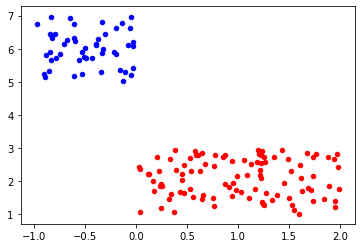

In [5]:
plt.scatter(M1[:,0], M1[:,1], s=20, c='r')
plt.scatter(M2[:,0], M2[:,1], s=20, c='b')
plt.show()

Зададим число кластеров и склеим данные множества.

In [6]:
n_clusters = 2
M = np.concatenate([M1, M2], axis=0)

Опробуем обычный k-means из sklearn.

In [7]:
%time kmeans = KMeans(n_clusters).fit(M)
K = kmeans.labels_

CPU times: user 35.9 ms, sys: 10.3 ms, total: 46.2 ms
Wall time: 65.4 ms


Рисуем точки с учетом их принадлежности к кластеру.

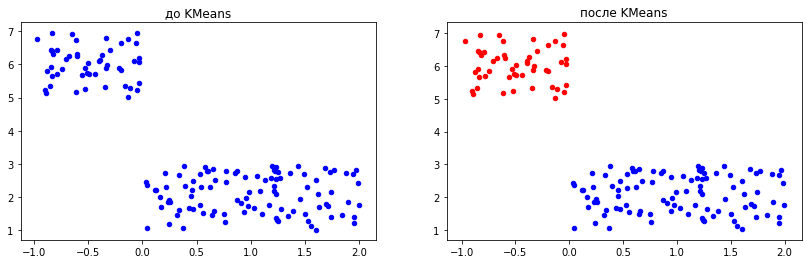

In [8]:
fig, (plt1, plt2)= plt.subplots(1, 2, figsize=(14,4))
plt1.set_title("до KMeans")
plt1.scatter(M[:, 0], M[:, 1], s=20, c='b')

plt2.set_title("после KMeans")
for i in range(len(M)):
    if K[i] == 0:
        plt2.scatter(M[i,0], M[i, 1], s=20, c='b')
    elif K[i] == 1:
        plt2.scatter(M[i,0], M[i, 1], s=20, c='r')   

## (ч.1) Приступим к набиванию шишек на собственном алгоритме k-means
Сделаем сначала для случая двух кластеров (используем только множество M, которое, напоминаю, является объединением M1 и M2 выше)

    1) Инициализируем кластеры
    2) Распределяем точки по кластерам
    3) Пересчитываем центры кластеров
    4) Проверяем условие останова    
Пойдем по пунктам.

#### 1) Инициализация кластеров

Инициализировать центры кластеров будем по самым удаленным друг от друга точкам, как на примере

example1.png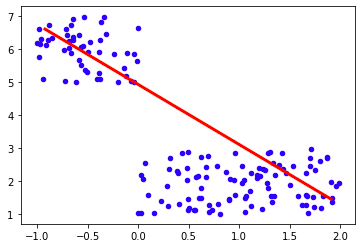

Решение: 
- выбираем случайную точку a1
- ищем самую удаленную от нее точку a2
- переходим в точку a2
- ищем снова самую удаленную точку a3

Ответ: точки a2, a3

##### Замечание: для поиска следующих точек, находим центр масс предыдущих и от него ищем самую удаленную. Такой подход оказался неприменимым (это показано дальше)

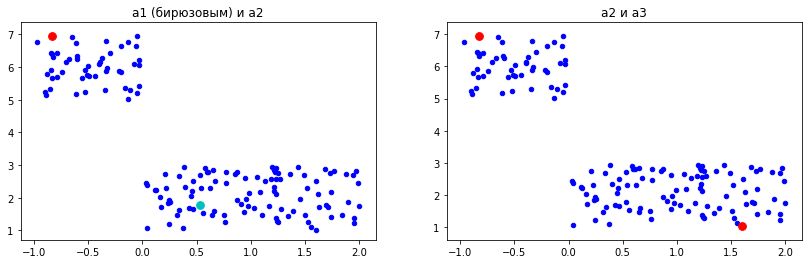

In [9]:
# пусть a1 будет первая точка
a1 = M[0,:]

# сделаем матрицу расстояний размера R^(n*1)
D = np.zeros(len(M))

# создадим матрицу размера как M, где все элементы - это координаты точки а1
E = np.ones(2*len(M)) 
E = E.reshape(len(M), 2)
A1 = E * a1

# высчитываем расстояние (используем теорему Пифагора) и ищем максимум
D = ((M[:,0] - A1[:,0]) ** 2 + (M[:,1] - A1[:,1]) ** 2) ** (1/2)
max2 = D.argmax()

# получили a2
a2 = M[max2,:]

# нарисуем точки a1 (бирюзовым), a2 (красным)
fig, (plt1, plt2)= plt.subplots(1, 2, figsize=(14,4))
plt1.set_title("a1 (бирюзовым) и a2")
plt1.scatter(M[:, 0], M[:, 1], s=20, c='b')
plt1.scatter(a1[0], a1[1], s=60, c='c')
plt1.scatter(a2[0], a2[1], s=60, c='r')

# ищем также a3
D = D * 0
A2 = E * a2
D = ((M[:,0] - A2[:,0]) ** 2 + (M[:,1] - A2[:,1]) ** 2) ** (1/2)
max3 = D.argmax()

a3 = M[max3,:]

# нарисуем точки a2, a3
plt2.set_title("a2 и a3")
plt2.scatter(M[:, 0], M[:, 1], s=20, c='b')
plt2.scatter(a2[0], a2[1], s=60, c='r')
plt2.scatter(a3[0], a3[1], s=60, c='r')

In [10]:
# переименуем полученные точки, это будут начальные центры кластеров
c0 = a2
c1 = a3

#### 2) Распределяем точки по кластерам

Подготовимся: сделаем матрицы нужных размеров

In [11]:
# напомню, что E это матрица из единиц размера len(M) * 2
C0 = E * c0
C1 = E * c1

# склеиваем (для вычисления расстояний будем использовать)
C = np.concatenate([C0, C1], axis=1)

# как в обычном kmeans сделаем массив принадлежности точек к  кластеру
labels = np.zeros(len(M), dtype="int")

# подготовим будущий массив расстояний
Dc = np.zeros(len(M)*n_clusters).reshape(len(M),n_clusters)

Основные вычисления:

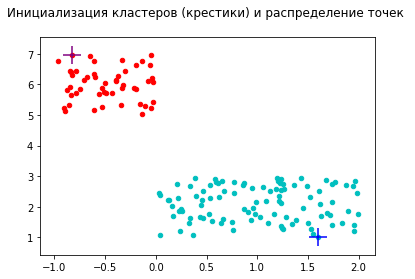

In [12]:
# высчитываем расстояния (каждое значение под ij матрицы Dc - это расстояние от j-ого центра кластера до i-ой точки множества)
for i in range(n_clusters):
    Dc[:,i:i+1] = ((M[:,0:1] - C[:,2*i:2*i+1]) ** 2 + (M[:,1:2] - C[:,2*i+1:2*i+2]) ** 2) ** (1/2)

# указываем принадлежность точек к кластеру в labels
for i in range(len(M)):
    labels[i] = Dc[i,:].argmin()

# рисуем точки с учетом принадлежности к кластеру
for i in range(len(M)):
    if labels[i] == 0:
        plt.scatter(M[i,0], M[i, 1], s=20, c='r')
    elif labels[i] == 1:
        plt.scatter(M[i,0], M[i, 1], s=20, c='c')

# выделим центры кластеров
plt.title("Инициализация кластеров (крестики) и распределение точек \n")
plt.scatter(c0[0], c0[1], s=300, c='purple', marker='+')
plt.scatter(c1[0], c1[1], s=300, c='blue', marker='+')
plt.show()

#### 3) Пересчитываем центры кластеров

Ищем центр масс кластеров.

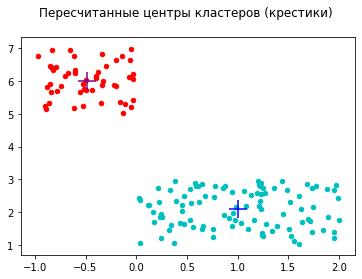

In [13]:
# создаем массив кол-ва точек, принадлежащих j-ому кластеру
# TODO конечно нужно сразу считать кол-во, когда принадлежность определяем, но мы идем по шагам
N = np.zeros(n_clusters, dtype="int")

# тут уже делаю массив координат центров класстера
# обнуляем для посчета новых координат
centers = np.zeros(n_clusters*2).reshape(n_clusters,2)

# считаем
j = 0
for i in labels:
    N[i] += 1
    centers[i,:] += M[j,:]
    j += 1

# наконец среднеарифметическое
for i in range(n_clusters):
    centers[i,:] = centers[i,:] / N[i]

# снова рисуем точки с учетом принадлежности к кластеру
for i in range(len(M)):
    if labels[i] == 0:
        plt.scatter(M[i,0], M[i, 1], s=20, c='r')
    elif labels[i] == 1:
        plt.scatter(M[i,0], M[i, 1], s=20, c='c')

# выделим новые центры кластеров (крестики)
plt.title("Пересчитанные центры кластеров (крестики) \n")
plt.scatter(centers[0,0], centers[0,1], s=300, c='purple', marker='+')
plt.scatter(centers[1,0], centers[1,1], s=300, c='blue', marker='+')
plt.show()


#### 4) Проверяем условие останова

- Условия могут быть следующими
    - количество итераций
    - стабилизация центра кластера (смещение центра кластера < заданного epsilon)

## (ч.2)  Оформим это все в виде функций

ПРОБЛЕМА: полученные центры кластеров, при n_clusters =  5 
 Некоторые точки равны
[[-0.83056723  6.94862014]
 [ 1.60298969  1.02733326]
 [ 1.60298969  1.02733326]
 [-0.83056723  6.94862014]
 [-0.83056723  6.94862014]]


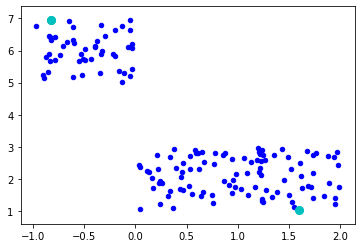

In [14]:
def centers_init(n_clusters, M): # возвращает массив centers
    centers = np.zeros(n_clusters*2).reshape(n_clusters,2)
    D = np.zeros(np.size(M[:,0])) # массив расстояний
    E = np.ones(2*np.size(M[:,0])).reshape(np.size(M[:,0]), 2) # всего лишь единичная матрица
    centers[0,:] = M[0,:] # опорная точка
    C = E * centers[0,:]
    for i in range(n_clusters):
        D -= D
        D = ((M[:,0] - C[:,0]) ** 2 + (M[:,1] - C[:,1]) ** 2) ** (1/2) # считаем расстояния до остальных точек
        index_max = D.argmax() # берем самую удаленную точку
        centers[i,:] = M[index_max,:] # сохраняем ее
        # ищем центр масс центров кластеров, чтобы взять следующую удаленную точку
        sum_coord = 0
        for j in range(i+1):
            sum_coord += centers[j,:]
        C = E * (sum_coord / (j+1))
        
    # !!! проблемы с такой инициализацией, следующие точки могут попадать в уже определенные центры кластеров !!!
    print("ПРОБЛЕМА: полученные центры кластеров, при n_clusters = ", n_clusters, "\n Некоторые точки равны")
    print(centers)
    # рисую
    plt.scatter(M[:, 0], M[:, 1], s=20, c='b')
    for i in range(n_clusters):
        plt.scatter(centers[i,0], centers[i,1], s=60, c='c')
    plt.show()

#=====================================================================================
n_clusters = 5

centers_init(n_clusters, M)

Тут я и получил шишку.
- точки могут попадать несколько раз в уже инициализованные центры кластеров

Я это не учел.
Нужно изменить подход к иницализации кластеров.

## (ч.3)  Другой способ инициализировать центры кластеров и k-means

Теперь попробуем брать случайным образом точки и обозначать их центрами кластеров.

Возможно, при таком подходе, на этапе пересчета центров кластеров, группы точек будут "перетягивать" к себе эти центры.

Проверим на практике (cразу начнем оформлять в виде функций).

#### 1) Инициализация центров

In [15]:
# можно менять и после этого запускать следующую ячейку
n_clusters = 4

Координаты случайно выбранных центров 
 [[ 0.53786064  2.29731646]
 [-0.52585276  5.2450802 ]
 [ 1.62376384  2.10360507]
 [-0.67373918  6.25355114]]


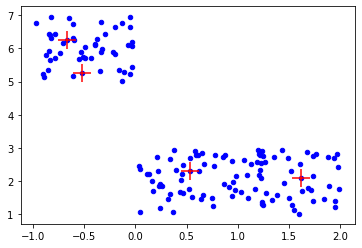

In [16]:
# функция инициализации центров кластеров
def centers_init(n_clusters, M): # возвращает массив centers
    centers = np.zeros(n_clusters*2).reshape(n_clusters,2)
    centers_ids = np.random.choice(np.size(M)//2, n_clusters, replace = False)
    for i in range(n_clusters):
        centers[i,:] = M[centers_ids[i],:]
    return centers
    
#=====================================================================================

centers = centers_init(n_clusters, M)
print('Координаты случайно выбранных центров \n',centers)

# рисую
plt.scatter(M[:, 0], M[:, 1], s=20, c='b')
for i in range(n_clusters):
    plt.scatter(centers[i,0], centers[i,1], s=300, c='r', marker='+')
plt.show()

#### 2) Распределение точек по кластерам

Обратите внимание на масштаб осей


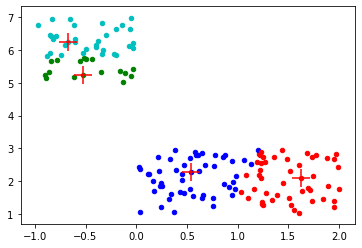

In [17]:
def clustering(centers, M): #возвращает labels
    E = np.ones(2*np.size(M[:,0])).reshape(np.size(M[:,0]), 2) # всего лишь единичная матрица
    # как в обычном kmeans сделаем массив принадлежности точек к  кластеру
    labels = np.zeros(len(M), dtype="int")
    # склеиваем матрицы размера len(M) * 2 с координатами центров (для вычисления расстояний будем использовать)
    C = np.array(E * centers[0,:])
    for i in range(1, np.size(centers) // 2):
        C = np.concatenate([C, E * centers[i,:]], axis=1)
    # подготовливаем массив расстояний
    Dc = np.zeros(len(M)*n_clusters).reshape(len(M),n_clusters)
    # высчитываем расстояния (каждое значение под ij матрицы Dc - это расстояние от j-ого кластера до i-ой точки множества)
    for i in range(n_clusters):
        Dc[:,i:i+1] = ((M[:,0:1] - C[:,2*i:2*i+1]) ** 2 + (M[:,1:2] - C[:,2*i+1:2*i+2]) ** 2) ** (1/2)
    # указываем принадлежность точек к кластеру в labels
    for i in range(len(M)):
        labels[i] = Dc[i,:].argmin()
    return labels
    
#=====================================================================================

labels = clustering(centers, M)

# рисуем точки с учетом принадлежности к кластеру
# TODO научиться делать контрастные цвета для произвольного числа кластеров
colors = ['b','g','r','c','m','y','k']
print('Обратите внимание на масштаб осей')
for i in range(len(M)):
    plt.scatter(M[i,0], M[i, 1], s=20, c=colors[labels[i]])
# отмечаем центры
for i in range(n_clusters):
    plt.scatter(centers[i,0], centers[i,1], s=300, c='r', marker='+')

#### 3) Перевычисление центров кластеров

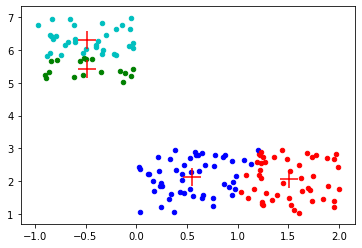

In [18]:
def centers_reinit(labels, M): # возвращает centers
    # массив для подсчета точек в кластерах
    N = np.zeros(n_clusters, dtype="int")
    # нулевые центры для посчета новых координат
    centers = np.zeros(n_clusters*2).reshape(n_clusters,2)
    # считаем точки в i-ом кластере и складываем их координаты
    j = 0
    for i in labels:
        N[i] += 1
        centers[i,:] += M[j,:]
        j += 1
    # считаем среднеарифметическое
    for i in range(n_clusters):
        centers[i,:] = centers[i,:] / N[i]
    return centers

#=====================================================================================

centers = centers_reinit(labels, M)

# рисуем
for i in range(len(M)):
    plt.scatter(M[i,0], M[i, 1], s=20, c=colors[labels[i]])
# отмечаем центры
for i in range(n_clusters):
    plt.scatter(centers[i,0], centers[i,1], s=300, c='r', marker='+')

#### 4) Условие останова

Считаем длину смещения центров.

In [47]:
def dif_centers(centers, old_centers):
    centers = centers - old_centers
    epsilon = (((centers[:,0]) ** 2 + (centers[:,1]) ** 2) ** (1/2)).max()
    return epsilon

#### Оформим k-means целиком

Условие останова - устойчивость центров кластеров.

In [48]:
# тут присутствует блок кода рисовки и параметр ее включения, для наглядности
def MyKMeans(n_clusters, M, epsilon, mode): # возвращает labels, параметр mode для рисовки
    centers = centers_init(n_clusters, M)
    # для запуска цикла
    old_centers = np.copy(centers)
    old_centers = -old_centers
    # на всякий случай счетчик
    counter = 0
    while (dif_centers(centers, old_centers) > epsilon):
        old_centers = np.copy(centers)
        labels = clustering(centers, M)
        centers = centers_reinit(labels, M)
        counter += 1
        if counter > 1000:
            print('counter reached limit!')
            break
        if mode == 1: 
            # рисуем
            plt.title('iteration ' + str(counter))
            for i in range(len(M)):
                plt.scatter(M[i,0], M[i, 1], s=20, c=colors[labels[i]])
            # отмечаем центры (крестиком)
            for i in range(n_clusters):
                plt.scatter(centers[i,0], centers[i,1], s=300, c='r', marker='+')
            plt.show()
    return labels

In [49]:
# можно менять и смотреть изменения в следующей ячейке
# условие останова
epsilon = 1/1000
# кол-во кластеров
n_clusters = 2
# поставьте mode = 0 для подсчета реального времени работы алгоритма (отключает рисовку)
mode = 1

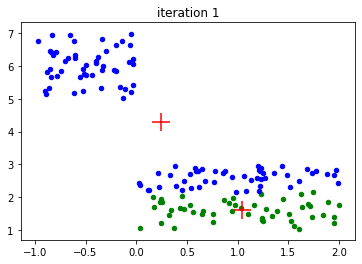

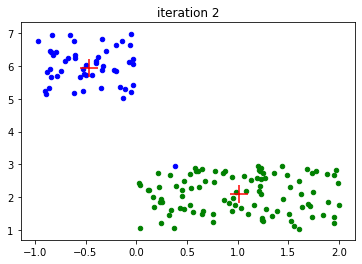

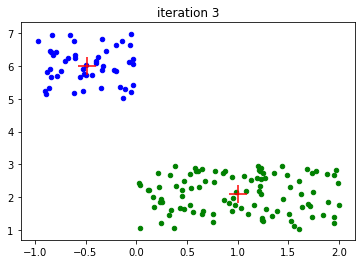

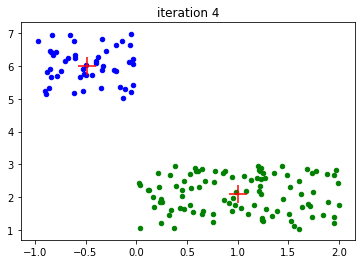

CPU times: user 4.89 s, sys: 366 ms, total: 5.26 s
Wall time: 5.36 s


In [50]:
%time labels = MyKMeans(n_clusters, M, epsilon, mode)

## (ч.4)  Тестируем

Придумаем забавные множества. Например, такие...

In [23]:
Mtest1 = np.array([[0, 0]])
i = 0
while (i < 400):
    X1 = 3 - 6 * np.random.rand(1,1)
    Y1 = 3 - 6 * np.random.rand(1,1)
    M1 = np.concatenate([X1,Y1], axis=1)
    d = X1[:] ** 2 + Y1[:] ** 2
    if (d < 1 or 3 < d < 6):
        Mtest1 = np.concatenate([Mtest1, M1], axis=0)
        i+=1

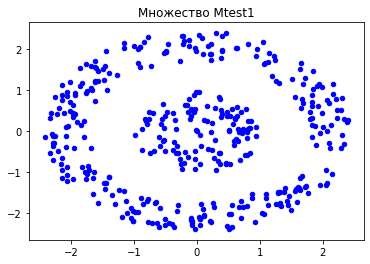

In [24]:
plt.title('Множество Mtest1')
plt.scatter(Mtest1[:,0], Mtest1[:,1], s=20, c='b')
plt.show()

In [25]:
Mtest2 = np.array([[0, 1]])
i = 0
while (i < 400):
    X1 = 10 * np.random.rand(1,1)
    Y1 = 5 * np.random.rand(1,1)
    M1 = np.concatenate([X1,Y1], axis=1)
    f1 = 1 + np.sin(X1[:])
    f2 = 2 + np.sin(X1[:])
    if (f1 < Y1 < f2):
        Mtest2 = np.concatenate([Mtest2, M1], axis=0)
        i+=1
    f1 = 3 + np.sin(X1[:])
    f2 = 4 + np.sin(X1[:])
    if (f1 < Y1 < f2):
        Mtest2 = np.concatenate([Mtest2, M1], axis=0)
        i+=1

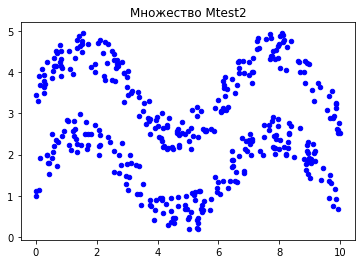

In [26]:
plt.title('Множество Mtest2')
plt.scatter(Mtest2[:,0], Mtest2[:,1], s=20, c='b')
plt.show()

In [27]:
Mtest3 = np.array([[-5, 2]])
i = 0
while (i < 500):
    X1 = 6 - 12 * np.random.rand(1,1)
    Y1 = 6 - 12 * np.random.rand(1,1)
    M1 = np.concatenate([X1,Y1], axis=1)
    d1 = ((X1[:] + 6) / 4) ** 2 + (Y1[:] / 2) ** 2
    d2 = ((X1[:] + 6) / 6) ** 2 + (Y1[:] / 4) ** 2
    if (d1 > 1 and d2 < 1):
        Mtest3 = np.concatenate([Mtest3, M1], axis=0)
        i+=1
    X1 = 6 - 12 * np.random.rand(1,1)
    Y1 = 6 - 12 * np.random.rand(1,1)
    M1 = np.concatenate([X1,Y1], axis=1)
    d1 = ((X1[:] - 6) / 4) ** 2 + (Y1[:] / 2) ** 2
    d2 = ((X1[:] - 6) / 6) ** 2 + (Y1[:] / 4) ** 2
    if (d1 > 1 and d2 < 1):
        Mtest3 = np.concatenate([Mtest3, M1], axis=0)
        i+=1

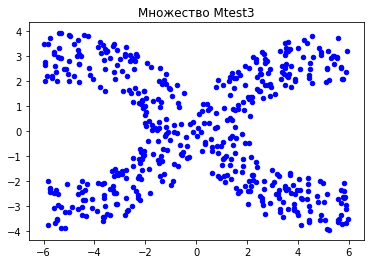

In [28]:
plt.title('Множество Mtest3')
plt.scatter(Mtest3[:,0], Mtest3[:,1], s=20, c='b')
plt.show()

Еще раз напишем сюда алгоритм, без рисовки уже

In [29]:
# еще раз запишем алгоритм без блока рисовки
def MyKMeans(n_clusters, M, epsilon):
    centers = centers_init(n_clusters, M)
    old_centers = np.copy(centers)
    old_centers = -old_centers
    counter = 0
    while (dif_centers(centers, old_centers) > epsilon):
        old_centers = np.copy(centers)
        labels = clustering(centers, M)
        centers = centers_reinit(labels, M)
        counter += 1
        if counter > 1000:
            print('counter reached limit!')
            break
    return labels

Кормим kmeans этими множествами.

Первое...

In [30]:
# можете менять это
epsilon = 1/500
# классные картинки при n_clusters = 4
# а при n_clusters = 6 вообще аттракцион
n_clusters = 2

In [31]:
%time labels = MyKMeans(n_clusters, Mtest1, epsilon)
%time kmeans = KMeans(n_clusters).fit(Mtest1) # обычный kmeans
K = kmeans.labels_

CPU times: user 57.3 ms, sys: 3.45 ms, total: 60.8 ms
Wall time: 58.2 ms
CPU times: user 51 ms, sys: 561 µs, total: 51.5 ms
Wall time: 51.8 ms


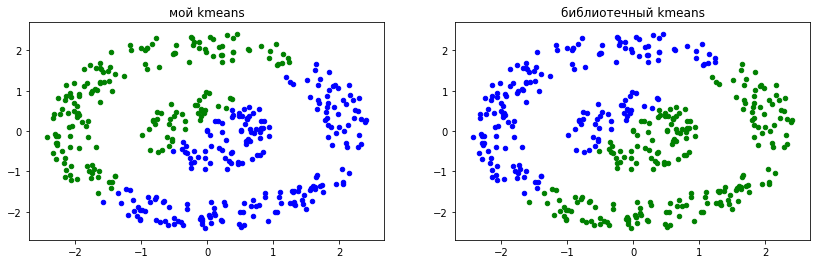

In [32]:
fig, (plt1, plt2)= plt.subplots(1, 2, figsize=(14,4))
plt1.set_title("мой kmeans")
for i in range(len(Mtest1)):
    plt1.scatter(Mtest1[i,0], Mtest1[i, 1], s=20, c=colors[labels[i]])

plt2.set_title("библиотечный kmeans")
for i in range(len(Mtest1)):
    plt2.scatter(Mtest1[i,0], Mtest1[i, 1], s=20, c=colors[K[i]])

А теперь второе...

In [33]:
# можете менять это
epsilon = 1/1000
n_clusters = 4

In [34]:
%time labels = MyKMeans(n_clusters, Mtest2, epsilon)
%time kmeans = KMeans(n_clusters).fit(Mtest2) # обычный kmeans
K = kmeans.labels_

CPU times: user 46.8 ms, sys: 2.91 ms, total: 49.7 ms
Wall time: 49 ms
CPU times: user 103 ms, sys: 1.29 ms, total: 104 ms
Wall time: 106 ms


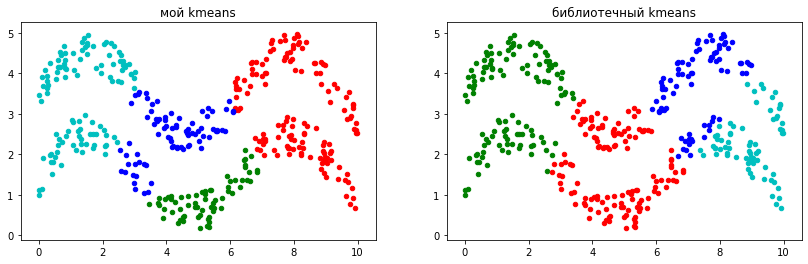

In [35]:
fig, (plt1, plt2)= plt.subplots(1, 2, figsize=(14,4))
plt1.set_title("мой kmeans")
for i in range(len(Mtest2)):
    plt1.scatter(Mtest2[i,0], Mtest2[i, 1], s=20, c=colors[labels[i]])
plt2.set_title("библиотечный kmeans")
for i in range(len(Mtest2)):
    plt2.scatter(Mtest2[i,0], Mtest2[i, 1], s=20, c=colors[K[i]])

Здесь уже можно наблюдать, что алгоритм чувствителен к начальной инициализации центров.

Третье...

In [36]:
# можете менять это
epsilon = 1/500
n_clusters = 2

In [37]:
%time labels = MyKMeans(n_clusters, Mtest3, epsilon)
%time kmeans = KMeans(n_clusters).fit(Mtest3) # обычный kmeans
K = kmeans.labels_

CPU times: user 28.5 ms, sys: 2.99 ms, total: 31.4 ms
Wall time: 35.7 ms
CPU times: user 50 ms, sys: 1.22 ms, total: 51.2 ms
Wall time: 61.9 ms


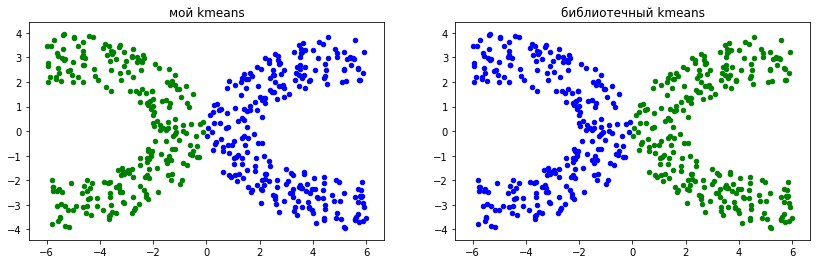

In [38]:
fig, (plt1, plt2)= plt.subplots(1, 2, figsize=(14,4))
plt1.set_title("мой kmeans")
for i in range(len(Mtest3)):
    plt1.scatter(Mtest3[i,0], Mtest3[i, 1], s=20, c=colors[labels[i]])
plt2.set_title("библиотечный kmeans")
for i in range(len(Mtest3)):
    plt2.scatter(Mtest3[i,0], Mtest3[i, 1], s=20, c=colors[K[i]])

Получилось интересно и красиво.

Теперь рассмотрим следующее множество...

In [39]:
Mtest4 = np.array([[0, 0]])
X1 = 10 * np.random.rand(20,1)
Y1 = 10 * np.random.rand(20,1)
M1 = np.concatenate([X1,Y1], axis=1)

X1 = 10 - 1 * np.random.rand(30,1)
Y1 = 10 - 1 * np.random.rand(30,1)
M2 = np.concatenate([X1,Y1], axis=1)

X1 = 1 + 2 * np.random.rand(100,1)
Y1 = 2 + 2 * np.random.rand(100,1)
M3 = np.concatenate([X1,Y1], axis=1)

X1 = 8 - 2 * np.random.rand(100,1)
Y1 = 8 - 2 * np.random.rand(100,1)
M4 = np.concatenate([X1,Y1], axis=1)

X1 = 1 + 2 * np.random.rand(100,1)
Y1 = 8 + 2 * np.random.rand(100,1)
M5 = np.concatenate([X1,Y1], axis=1)

Mtest4 = np.concatenate([Mtest4, M1, M2, M3, M4, M5], axis=0)

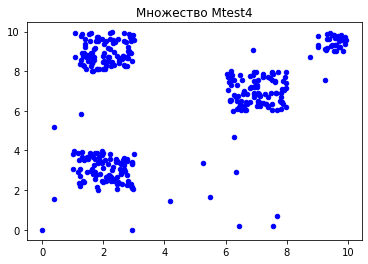

In [40]:
plt.title('Множество Mtest4')
plt.scatter(Mtest4[:,0], Mtest4[:,1], s=20, c='b')
plt.show()

In [41]:
# можете менять это и запускать следующие ячейки
epsilon = 1/1000
n_clusters = 4

In [42]:
%time labels = MyKMeans(n_clusters, Mtest4, epsilon)
%time kmeans = KMeans(n_clusters).fit(Mtest4) # обычный kmeans
K = kmeans.labels_

CPU times: user 22.2 ms, sys: 2.47 ms, total: 24.7 ms
Wall time: 27 ms
CPU times: user 78.9 ms, sys: 1.38 ms, total: 80.3 ms
Wall time: 84.9 ms


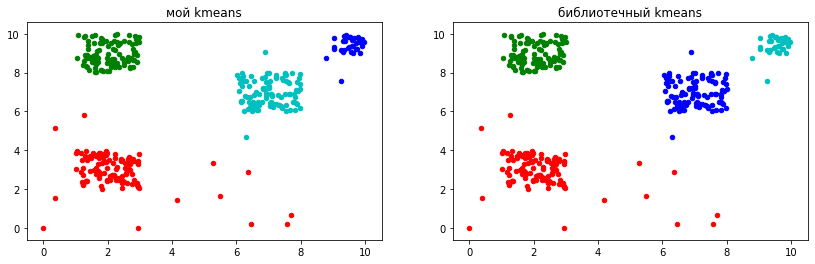

In [43]:
fig, (plt1, plt2)= plt.subplots(1, 2, figsize=(14,4))
plt1.set_title("мой kmeans")
for i in range(len(Mtest4)):
    plt1.scatter(Mtest4[i,0], Mtest4[i, 1], s=20, c=colors[labels[i]])
plt2.set_title("библиотечный kmeans")
for i in range(len(Mtest4)):
    plt2.scatter(Mtest4[i,0], Mtest4[i, 1], s=20, c=colors[K[i]])

Тут аналогично, алгоритм сильно зависим от инициализации. К тому же мой алгоритм может часто брать два больших множества за один кластер (опять же виновата начальная инициализация), что за библиотечным k-means замечено было реже.

## (ч.5)  Итог: код

In [44]:
def centers_init(n_clusters, M):
    centers = np.zeros(n_clusters*2).reshape(n_clusters,2)
    centers_ids = np.random.choice(np.size(M)//2, n_clusters, replace = False)
    for i in range(n_clusters):
        centers[i,:] = M[centers_ids[i],:]
    return centers

def clustering(centers, M):
    E = np.ones(2*np.size(M[:,0])).reshape(np.size(M[:,0]), 2)
    labels = np.zeros(len(M), dtype="int")
    C = np.array(E * centers[0,:])
    Dc = np.zeros(len(M)*n_clusters).reshape(len(M),n_clusters)
    for i in range(1, np.size(centers) // 2):
        C = np.concatenate([C, E * centers[i,:]], axis=1)
    for i in range(n_clusters):
        Dc[:,i:i+1] = ((M[:,0:1] - C[:,2*i:2*i+1]) ** 2 + (M[:,1:2] - C[:,2*i+1:2*i+2]) ** 2) ** (1/2)
    for i in range(len(M)):
        labels[i] = Dc[i,:].argmin()
    return labels

def centers_reinit(labels, M):
    N = np.zeros(n_clusters, dtype="int")
    centers = np.zeros(n_clusters*2).reshape(n_clusters,2)
    j = 0
    for i in labels:
        N[i] += 1
        centers[i,:] += M[j,:]
        j += 1
    for i in range(n_clusters):
        centers[i,:] = centers[i,:] / N[i]
    return centers

def dif_centers(centers, old_centers):
    centers = centers - old_centers
    epsilon = (((centers[:,0]) ** 2 + (centers[:,1]) ** 2) ** (1/2)).max()
    return epsilon

def MyKMeans(n_clusters, M, epsilon):
    centers = centers_init(n_clusters, M)
    old_centers = np.copy(centers)
    old_centers = -old_centers
    counter = 0
    while (dif_centers(centers, old_centers) > epsilon):
        old_centers = np.copy(centers)
        labels = clustering(centers, M)
        centers = centers_reinit(labels, M)
        counter += 1
        if counter > 1000:
            print('counter reached limit!')
            break
    return labels

Пример вызова функции

In [45]:
labels = MyKMeans(n_clusters, M, epsilon) # число кластеров, множество точек в R^2, точность

#### © Шулюгин Иван МГУ ВМК 215. ноябрь 2019

- telegram: vsha96